# Simple SED-ML example

This notebook creates a simple model in [SED-ML version 1 level 4](https://sed-ml.org/specifications.html). It builds a model of metabolite A degrading.

## 1) Including libraries

In [6]:
from combine_notebooks import RESULTS_DIR
import libsedml
import tellurium as te
import tempfile, os

## 2) Declaring the SED-ML model

First we create a SED-ML document at version 1 level 4.

In [7]:
doc = libsedml.SedDocument(1, 4)

Create a first model referencing an sbml file.

In [8]:
model = doc.createModel()
model.setId("model1")
model.setSource("sbml.xml")
model.setLanguage("urn:sedml:language:sbml.level-3.version-1") 

0

Create a simulation and set the important parameters (e.g. inital time, number of steps).  We also specify that we want to use the CVODE algorithm, which is a method for integrating ordinary differential equations.

In [9]:
# create simulation
tc = doc.createUniformTimeCourse()
tc.setId("sim1")
tc.setInitialTime(0.0)
tc.setOutputStartTime(0.0)
tc.setOutputEndTime(5.0)
tc.setNumberOfSteps(100)
# need to set the correct KISAO Term
alg = tc.createAlgorithm()
alg.setName("CVODE")
alg.setKisaoID("KISAO:0000019")

0

Create a task that uses the simulation and the model above.

In [10]:
task = doc.createTask()
task.setId("task1")
task.setModelReference("model1")
task.setSimulationReference("sim1")


0

Add three DataGenerator to hold the outputs.

In [11]:
dg = doc.createDataGenerator()
dg.setId("plot_0_0_0")
dg.setName("time")
var = dg.createVariable()
var.setId("time")
var.setTaskReference("task1")
var.setModelReference("model1")
var.setSymbol("urn:sedml:symbol:time")
dg.setMath(libsedml.parseFormula("time"))

dg = doc.createDataGenerator()
dg.setId("plot_0_0_1")
dg.setName("S1")
var = dg.createVariable()
var.setId("S1")
var.setTaskReference("task1")
var.setModelReference("model1")
var.setTarget("/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='S1']")
dg.setMath(libsedml.parseFormula("S1"))

dg = doc.createDataGenerator()
dg.setId("plot_0_1_1")
dg.setName("S2")
var = dg.createVariable()
var.setId("S2")
var.setTaskReference("task1")
var.setModelReference("model1")
var.setTarget("/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='S2']")
dg.setMath(libsedml.parseFormula("S2"))



0

Finally, we will create a 2d plot with two curves.

In [12]:
plot = doc.createPlot2D()
plot.setId("plot_0")
plot.setName("Figure 1")
curve = plot.createCurve()
curve.setId("plot_0__plot_0_0_0__plot_0_0_1")
curve.setLogX(False)
curve.setLogY(False)
curve.setXDataReference("plot_0_0_0")
curve.setYDataReference("plot_0_0_1")

curve = plot.createCurve()
curve.setId("plot_0__plot_0_0_0__plot_0_1_1")
curve.setLogX(False)
curve.setLogY(False)
curve.setXDataReference("plot_0_0_0")
curve.setYDataReference("plot_0_1_1")

0

## 3) Write and print the generated model

And we're done creating the basic model.
Now save a text string containing the model into a SED-ML file.

In [13]:
sedml_loc = str(RESULTS_DIR) + '/hello_world_sedml.sedml'
os.makedirs(os.path.dirname(sedml_loc), exist_ok=True)
libsedml.writeSedML(doc, sedml_loc)
sedml_str = open(sedml_loc).read()
print(sedml_str)


<?xml version="1.0" encoding="UTF-8"?>
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-1" source="sbml.xml"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="plot_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
      <listOfVariables>
        <variable id="time" symbol="urn:sedml:symbol:time" taskReference="task1" modelReference="model1"/>
      </listOfVariables>
    </dataGenerator>
    <dataGenerator id="plot_0_0_1" name="S1">
      <math xmlns="h

## 4) Simulating the model

In [14]:
te.setDefaultPlottingEngine('matplotlib')

# Load a SBML model we want to simulate
sbml_loc = str(RESULTS_DIR) + "/hello_world_sbml.xml"
sbml_str = open(sbml_loc).read()

# Load SED-ML string created in section 2
sedml_str = open(sedml_loc).read()

# Create a temporary directory to store SED-ML and SBML files
workingDir = tempfile.mkdtemp(suffix="_sedml")

# Get paths for a temporary file, the filename here should 
# match what is in our SED-ML document
sbml_file = os.path.join(workingDir, 'sbml.xml')

# Save SBML to the temporary file
with open(sbml_file, 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
    f.flush()
    print('SBML written to temporary file')

SBML written to temporary file


Read SED-ML file, number of errors: 0


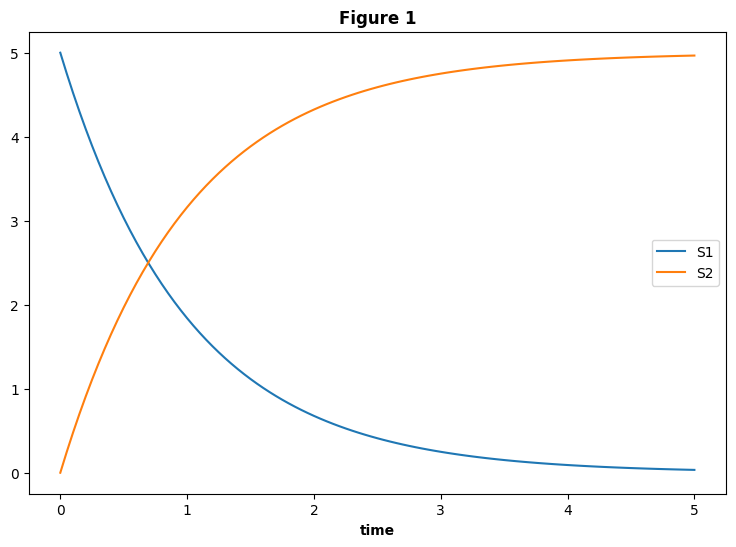

In [15]:
# Validate our SED-ML
n_errors = doc.getErrorLog().getNumFailsWithSeverity(libsedml.LIBSEDML_SEV_ERROR)
print('Read SED-ML file, number of errors: {}'.format(n_errors))
if n_errors > 0:
    print(doc.getErrorLog().toString())

# execute SED-ML using Tellurium
te.executeSEDML(sedml_str, workingDir=workingDir)